## GAAIMS: Predicting Multiple Sclerosis from Dynamics of Gait Variability Using an Instrumented Treadmill - A Machine Learning-Based Approach
## Foot Progression Angles (Right and Left)
#### Refer https://jneuroengrehab.biomedcentral.com/articles/10.1186/s12984-018-0419-2 for definitions of FPAs

### Package imports 

In [1]:
import numpy as np
import pandas as pd
import math
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = 'C:\\Users\\Rachneet Kaur\\Dropbox\\GAIT\\sample_data\\data_export\\'

In [3]:
# Get all the file names in the dictionary
control_ids = list(range(200, 220))
ms_ids = list(range(300, 315)) + [318, 320, 321, 322, 323]
raw_controls_t1 = [path +str(i)+ '_B3_TRIAL01_RAWDATA.csv' for i in control_ids]
raw_controls_t2 = [path +str(i)+ '_B3_TRIAL02_RAWDATA.csv' for i in control_ids]

raw_ms_t1 = [path +str(i)+ '_B3_TRIAL01_RAWDATA.csv' for i in ms_ids]
raw_ms_t2 = [path +str(i)+ '_B3_TRIAL02_RAWDATA.csv' for i in ms_ids]

gait_controls_t1 = [path +str(i)+ '_B3_TRIAL01_GAITCYCLES.csv' for i in control_ids]
gait_controls_t2 = [path +str(i)+ '_B3_TRIAL02_GAITCYCLES.csv' for i in control_ids]

gait_ms_t1 = [path +str(i)+ '_B3_TRIAL01_GAITCYCLES.csv' for i in ms_ids]
gait_ms_t2 = [path +str(i)+ '_B3_TRIAL02_GAITCYCLES.csv' for i in ms_ids]

In [4]:
# for every GaitCycle file, a sequence of walk will always start with a heel strike on the right foot.
# Thus the order of the Gait event points would be HSR, TOL, MidSSR, HSL, TOR and MidSSL.
gait_type = np.array(['HSR', 'TOL', 'MidSSR', 'HSL', 'TOR', 'MidSSL'])

#Delta_time
delta_time = 0.002 #Since the data is collected is 500Hz frequency 

### Utility functions

In [5]:
#functions to drop missing values and invalid data 
def drop_unnamed(dataframe):
    return(dataframe.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1))

#Eliminate missing values
def drop_na(dataframe):
    return(pd.DataFrame.dropna(dataframe))

#Eliminate invalid data 
def get_valid(dataframe):
    return(dataframe.loc[dataframe.Valid == True, :])

# Valid strides in the gait_cycles.csv file 
def get_cycle(dataframe):
    stride_start = min(dataframe.loc[dataframe.EventType == 'HSR'].index)
    stride_end = max(dataframe.loc[dataframe.EventType == 'MidSSL'].index)   
    return dataframe.loc[stride_start:stride_end]

# Restore the indexing for the cropped dataframe 
def change_index(dataframe):
    dataframe.index = range(len(dataframe))
    return dataframe

# get all the valid index in order: HSR-TOL-MidSSR-HSL-TOR-MidSSL
def set_complete(data_frame):
    # input is the Dataframe includes ONLY valid points 
    # get all the index of HSR since it starts with heal strike left
    # if the length of last gait cycle contain HSR does not equals to 6, then ignore it
    
    HSR = data_frame.loc[data_frame.EventType == 'HSR'].index
    last_idx = HSR[-1]
    last_all_idx = data_frame.index[-1]
    # if the last gait cycles contains HSR is not a valid gait cycle, then we should consider the last second HSR instead.
    if((last_all_idx-last_idx) < 5):
        HSR = HSR[0:-1] 
    else:
        HSR = HSR
    
    # get all the valid index in order: HSR-TOL-MidSSR-HSL-TOR-MidSSL
    valid = []
    for idx_HSR in HSR:
        if (((idx_HSR + 1) in data_frame.index) & ((idx_HSR + 2) in data_frame.index) &
            ((idx_HSR + 3) in data_frame.index) & ((idx_HSR + 4) in data_frame.index) & 
            ((idx_HSR + 5) in data_frame.index)):
            # the valid index exist in the dataframe.
            if((data_frame.loc[idx_HSR + 1].EventType == 'TOL') & (data_frame.loc[idx_HSR + 2].EventType == 'MidSSR') & 
               (data_frame.loc[idx_HSR + 3].EventType == 'HSL') & (data_frame.loc[idx_HSR + 4].EventType == 'TOR') & 
               (data_frame.loc[idx_HSR + 5].EventType == 'MidSSL')):
                valid.extend(range(idx_HSR, idx_HSR+6))
    #returns the list of valid indices which form complete strides 
    return valid

### Data Preprocessing

In [6]:
#Preprocessing the files to delete missing and invalid data 
#For each person (control and MS) in Trial 1
def cleaning(pid, trial = 1, cohort = 'controls'):
    if (cohort == 'controls'):
        if (trial == 1):
            gait = pd.read_csv(gait_controls_t1[pid])
            raw = pd.read_csv(raw_controls_t1[pid])
        else:
            gait = pd.read_csv(gait_controls_t2[pid])
            raw = pd.read_csv(raw_controls_t2[pid])            
    
    if (cohort == 'pwms'):
        if (trial == 1):
            gait = pd.read_csv(gait_ms_t1[pid])
            raw = pd.read_csv(raw_ms_t1[pid])
        else:
            gait = pd.read_csv(gait_ms_t2[pid])
            raw = pd.read_csv(raw_ms_t2[pid])            
    gait = drop_na(gait)
    gait  = get_valid(gait)

    #Reducing to complete strides data 
    gait = get_cycle(gait)
    indices_complete = set_complete(gait)
    gait = gait.loc[indices_complete]

    #Resetting the index 
    gait = change_index(gait)
    return indices_complete, gait, raw

### Calculating the foot progression angles

In [7]:
#Foot progression angle - right foot
def FPA_right(x1, x2, y1, y2):
    return np.arctan2((y2 - y1), (x2 - x1)) / math.pi *  180

#Left foot progression angle 
def FPA_left(x1, x2, y1, y2):
    return np.arctan2((y2 - y1), (x2 - x1)) / math.pi * 180 * (-1)

In [8]:
#Foot Progression Calculator function given Patient ID, Trial ID and cohort 
def FPA_calculator(pid, trial_id, cohort):
    indices_complete, gait, raw = cleaning(pid, trial_id, cohort)

    stride_count = int(gait.shape[0]/6) #6 events in each stride

    #Exact times of HSR
    HSR_times = gait['Time'][gait.EventType == 'HSR']
    #Exact times of TOR 
    TOR_times = gait['Time'][gait.EventType == 'TOR']
    #Exact times of HSL
    HSL_times = gait['Time'][gait.EventType == 'HSL']
    #Exact times of TOL 
    TOL_times = gait['Time'][gait.EventType == 'TOL']

    #X for HSR
    HSR_X = gait['X'][gait.EventType == 'HSR']
    #X for TOR 
    TOR_X = gait['X'][gait.EventType == 'TOR']
    #X for HSL
    HSL_X = gait['X'][gait.EventType == 'HSL']
    #X for TOL
    TOL_X = gait['X'][gait.EventType == 'TOL']

    #Y for HSR
    HSR_Y = gait['Y'][gait.EventType == 'HSR']
    #Y for TOR 
    TOR_Y = gait['Y'][gait.EventType == 'TOR']
    #Y for HSL
    HSL_Y = gait['Y'][gait.EventType == 'HSL']
    #Y for TOL
    TOL_Y = gait['Y'][gait.EventType == 'TOL']

    #For four events of interest, calculate the closest times from RAWDATA.csv file 
    HSR_times_raw = [raw['Time'][raw['Time']>HSR_times.iloc[i]].iloc[0] for i in range(stride_count)]
    TOR_times_raw = [raw['Time'][raw['Time']>TOR_times.iloc[i]].iloc[0] for i in range(stride_count)]
    HSL_times_raw = [raw['Time'][raw['Time']>HSL_times.iloc[i]].iloc[0] for i in range(stride_count)]
    TOL_times_raw = [raw['Time'][raw['Time']>TOL_times.iloc[i]].iloc[0] for i in range(stride_count)]

    rely_progR = []
    rely_footR = []
    rely_progL = []
    rely_footL = []

    for idx in range(0, stride_count): #Use for all strides for each person, each trial
        try:
            #For Right Foot
            #Relative y indices for HSR(i-1) to HSR(i) 
            rely_prog_idxR = (raw['Time']>=HSR_times_raw[idx]) & (raw['Time']<HSR_times_raw[idx+1]) #Progression vector 

            #Relative y indices for HSR(i) to TOR(i) 
            rely_foot_idxR = (raw['Time']>=HSR_times_raw[idx+1]) & (raw['Time']<TOR_times_raw[idx+1]) #Foot direction vector

            #Relative_y or Belt Speed = Speed*dt = Area under the speed curve *dt for HSR(i-1) to HSR(i)
            rely_progR.append(np.trapz(raw['Speed'][rely_prog_idxR])*0.002) 

            #Relative_y or Belt Speed = Speed*dt = Area under the speed curve *dt for HSR(i) to TOR(i)
            rely_footR.append(np.trapz(raw['Speed'][rely_foot_idxR])*0.002) 

            #For Left Foot 
            #Relative y indices for HSL(i-1) to HSL(i) 
            rely_prog_idxL = (raw['Time']>=HSL_times_raw[idx]) & (raw['Time']<HSL_times_raw[idx+1]) #Progression vector 

            #Relative y indices for HSL(i) to TOL(i+1) 
            rely_foot_idxL = (raw['Time']>=HSL_times_raw[idx+1]) & (raw['Time']<TOL_times_raw[idx+2]) #Foot direction vector

            #Relative_y or Belt Speed = Speed*dt = Area under the speed curve *dt for HSL(i-1) to HSL(i)
            rely_progL.append(np.trapz(raw['Speed'][rely_prog_idxL])*0.002) 

            #Relative_y or Belt Speed = Speed*dt = Area under the speed curve *dt for HSL(i) to TOL(i+1)
            rely_footL.append(np.trapz(raw['Speed'][rely_foot_idxL])*0.002) 
        except:
            pass

    #Right Foot 
    #HSR_Y after adding the relative y correspoding to previous HSR
    rel_HSR_Y = HSR_Y[1:].values+np.array(rely_progR) 
    #TOR_Y after adding the relative y corresponding to same foot HSR starting from foot 2
    rel_TOR_Y = TOR_Y[1:].values+np.array(rely_footR) 

    #Left Foot
    #HSL_Y of foot 2(stride 2) after adding the relative y correspoding to previous HSL (first and last one cannot be used)
    #First one cannot be used since we need first 2 to compute Heel-Heel angle
    #Last one cannot be used since we need TOL of next stride (which doesn't exist) to compute HeelLeft-Toe Left angle 
    rel_HSL_Y = HSL_Y[1:-1].values+np.array(rely_progL) 
    #TOL_Y of foot 2 (stride 3) after adding the relative y corresponding to same foot HSL starting from foot 2 
    #(first 2 will not be used)
    rel_TOL_Y = TOL_Y[2:].values+np.array(rely_footL) 

    #Right FPA
    #HSR-NextHSR angle with horizontal axis 
    HH_R = list(map(FPA_right, HSR_X[:-1].values, HSR_X[1:].values, HSR_Y[:-1].values, rel_HSR_Y))
    #HSR-TOR angle with horizontal axis starting from second HSR 
    HT_R = list(map(FPA_right, HSR_X[1:].values, TOR_X[1:].values, HSR_Y[1:].values, rel_TOR_Y))
    #Right Foot Progression angle = angle of HH with horixontal axis - angle of HT with horizontal axis
    rightFPA = np.array(HH_R)-np.array(HT_R)

    #Left FPA
    #HSL-NextHSL angle with horizontal axis 
    HH_L = list(map(FPA_left, HSL_X[:-2].values, HSL_X[1:-1].values, HSL_Y[:-2].values, rel_HSL_Y))
    #HSL-TOL angle with horizontal axis starting from second HSL
    HT_L = list(map(FPA_left, HSL_X[1:-1].values, TOL_X[2:].values, HSL_Y[1:-1].values, rel_TOL_Y))
    #Right Foot Progression angle = angle of HH with horixontal axis - angle of HT with horizontal axis
    leftFPA = np.array(HH_L)-np.array(HT_L)
    
    #Right Foot
    #Convert in-consequetive gait cycles' angles to NaN 
    stride_idx = np.array(indices_complete[::6][1:]) - np.array(indices_complete[::6][:-1])
    #If this difference is not 6, that means the valid strides is not in consequent order, hence, we cannot compute angles 
    rightFPA[np.where(stride_idx!=6)[0]] = np.nan
    #Total length must match the stride count 
    #For RFPA, append NaN at the beginning
    rightFPA = np.insert(rightFPA, 0, np.nan)

    #Left Foot
    #If this difference is not 6, that means the valid strides is not in consequent order, hence, we cannot compute angles 
    for x in np.where(stride_idx!=6)[0]:
        if ((x-1)>=0): #For 0th index, only 0 should be Nan, else, x-1 and x should be Nan
            leftFPA[x-1] = np.nan
        try: 
            #For last index, LeftFPA has length no. of strides-2, so, for the last stride to be non-consequetive, 
            #there will be no current LeftFPA value to be nullified 
            leftFPA[x] = np.nan
        except:
            pass
    #Total length must match the stride count 
    #For LFPA, append NaN at the beginning and at the end
    leftFPA = np.insert(leftFPA, 0, np.nan)
    leftFPA= np.append(leftFPA, np.nan)
    
    return leftFPA, rightFPA

### Creating the dataframe and storing in .csv

In [9]:
#Dataframe with Patient ID, Trial ID, (Right FPA, Left FPA for each stride)
df = pd.DataFrame()

cohorts = ['controls', 'pwms']
trials = [1, 2]
for trial_id in trials:
    for cohort in cohorts:
        for index in range(0, 20): #20 people in each cohort and each trial
            if cohort == 'controls':
                pid = control_ids[index]
            else:
                pid = ms_ids[index]
            leftFPA, rightFPA = FPA_calculator(index, trial_id, cohort)
            
            temp_df = pd.DataFrame(data = np.array([[pid]*len(leftFPA), [trial_id]*len(leftFPA), leftFPA, rightFPA]).T)
            df = df.append(temp_df, ignore_index= True)
df.columns = ['PID', 'TrialID', 'LeftFPA', 'RightFPA']

### Statistics and Plots 

In [10]:
df[:10]

,PID,TrialID,LeftFPA,RightFPA
0,200.0,1.0,NaN,NaN
1,200.0,1.0,0.454459,1.039040
2,200.0,1.0,-0.267919,-2.942001
3,200.0,1.0,0.669773,3.611119
4,200.0,1.0,-8.515633,3.855825
5,200.0,1.0,13.063372,-5.439336
6,200.0,1.0,-3.474319,1.169755
7,200.0,1.0,-4.613322,-2.827393
8,200.0,1.0,6.996230,8.947207
9,200.0,1.0,-1.971395,-5.192350


In [11]:
df['Label'] = [int (i) for i in df['PID']/100>=3] #Assigning 0 for Healthy, 1 for PwMS

In [12]:
print (df[(df['Label']==0)]['LeftFPA'].min(), df[(df['Label']==0)]['LeftFPA'].max())
print(df[(df['Label']==0)]['RightFPA'].min(), df[(df['Label']==0)]['RightFPA'].max())
print (df[(df['Label']==1)]['LeftFPA'].min(), df[(df['Label']==1)]['LeftFPA'].max())
print(df[(df['Label']==1)]['RightFPA'].min(), df[(df['Label']==1)]['RightFPA'].max())

print (df[(df['Label']==0)]['LeftFPA'].mean(), df[(df['Label']==0)]['LeftFPA'].std())
print(df[(df['Label']==0)]['RightFPA'].mean(), df[(df['Label']==0)]['RightFPA'].std())

print (df[(df['Label']==1)]['LeftFPA'].mean(), df[(df['Label']==1)]['LeftFPA'].std())
print(df[(df['Label']==1)]['RightFPA'].mean(), df[(df['Label']==1)]['RightFPA'].std())

-13.788412124975181 169.49961211412125
-211.16011000927992 207.8563820170504
-166.02596294913067 82.78939067152098
-63.59992381476697 183.1765758164122
0.5029926344062193 4.817368979756204
0.42452227375179846 7.280628517410553
0.07520461267428204 6.502792170671697
0.1860634610575886 6.87032814886635


In [13]:
#Saving csv file
#One with PatientID, TrialID, LeftFPA, RightFPA
df.to_csv(path+'..\\FPA\\FPA_feature.csv')

### Vizualizations (Box and Swarm plots) for trials W and WT

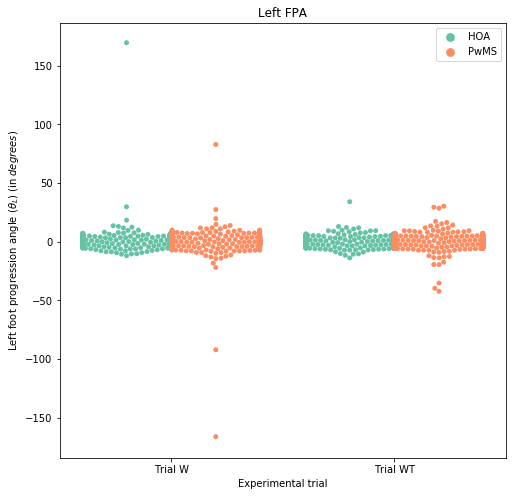

In [46]:
#Left FPA
#Trial W - Box plot without and with outliers  (swarmplot)
plt.figure(figsize = (8, 8))
# ax = sns.boxplot(x= 'TrialID', hue = 'Label', y='LeftFPA', data=df, linewidth=2.5, palette="Set3", 
#                  width=0.6, showfliers = False)
# ax = sns.violinplot(x= 'TrialID', hue = 'Label', y='LeftFPA', data=df, dodge = True, inner=None, split = True)
ax = sns.swarmplot(x= 'TrialID', hue = 'Label', y='LeftFPA', data=df, dodge = True, palette="Set2")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['HOA', 'PwMS'], loc = 'upper right')
plt.ylabel(r"Left foot progression angle ($\theta_L$) (in $degrees$)")
plt.xlabel('Experimental trial')
plt.xticks([0, 1], ['Trial W', 'Trial WT'])
plt.title('Left FPA')
# plt.savefig(path + '..\\butterfly\\boxplots\\x_abs_w_wt.png', dpi = 250) #Use Box plot here 
plt.savefig(path + '..\\FPA\\LeftFPA_swarm.png', dpi = 250) #Use Swarmplot here 
plt.show()


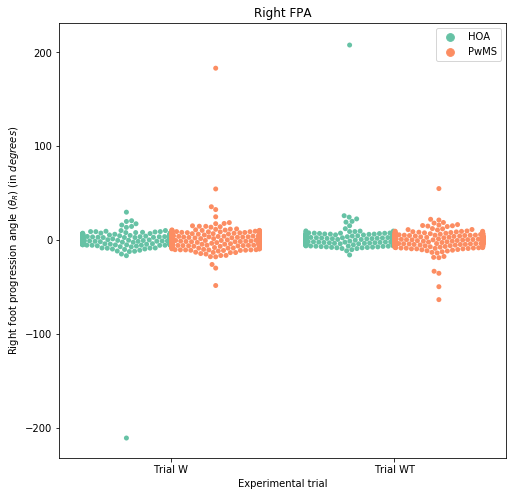

In [51]:
#Right FPA
#Trial W - Box plot without and with outliers  (swarmplot)
plt.figure(figsize = (8, 8))
# ax = sns.boxplot(x= 'TrialID', hue = 'Label', y='RightFPA', data=df, linewidth=2.5, palette="Set3", 
#                  width=0.6, showfliers = False)
# ax = sns.violinplot(x= 'TrialID', hue = 'Label', y='RightFPA', data=df, dodge = True, inner=None, split = True)
ax = sns.swarmplot(x= 'TrialID', hue = 'Label', y='RightFPA', data=df, dodge = True, palette="Set2")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['HOA', 'PwMS'], loc = 'upper right')
plt.ylabel(r"Right foot progression angle ($\theta_R$) (in $degrees$)")
plt.xlabel('Experimental trial')
plt.xticks([0, 1], ['Trial W', 'Trial WT'])
plt.title('Right FPA')
# plt.savefig(path + '..\\FPA\\RightFPA.png', dpi = 250) #Use Box plot here 
plt.savefig(path + '..\\FPA\\RightFPA_swarm.png', dpi = 250) #Use Swarmplot here 
plt.show()
